In [124]:
import warnings
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline

## Загрузка данных

In [2]:
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [138]:
negids = movie_reviews.fileids('neg')
posids = movie_reviews.fileids('pos')
negfeats = [' '.join(movie_reviews.words(fileids=[f])) for f in negids]
posfeats = [' '.join(movie_reviews.words(fileids=[f])) for f in posids]
print('Negative:', len(negfeats), 'Positive:', len(posfeats))

Negative: 1000 Positive: 1000


In [4]:
reviews = negfeats + posfeats
y = [0]*1000 + [1]*1000

In [5]:
data = pd.DataFrame({'reviews': reviews, 'y': y})
data

,reviews,y
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard ' s quick movie review damn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' first...",0
4,synopsis : a mentally unstable man undergoing ...,0
...,...,...
1995,wow ! what a movie . it ' s everything a movie...,1
1996,"richard gere can be a commanding actor , but h...",1
1997,"glory -- starring matthew broderick , denzel w...",1
1998,steven spielberg ' s second epic film on world...,1


In [6]:
train, test = train_test_split(data, test_size=0.25, shuffle=True, random_state=5)

## Описательный анализ данных

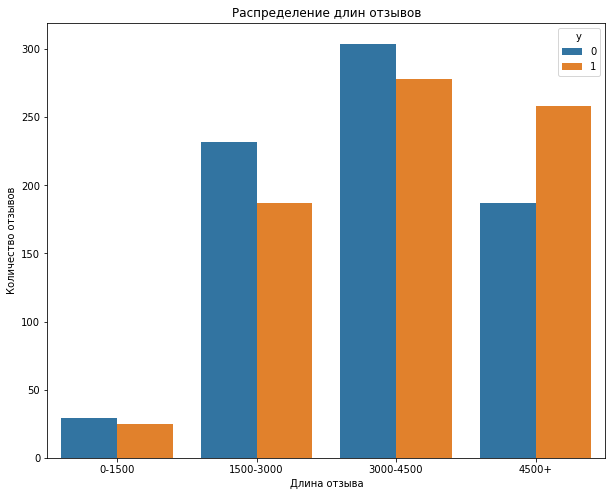

In [8]:
df = train.copy()
df['length'] = pd.cut(train.reviews.apply(lambda x: len(x)), bins=[0, 1500, 3000, 4500, float('inf')], 
       labels=['0-1500', '1500-3000', '3000-4500', '4500+'])

fig = plt.figure(figsize=(10, 8))
sns.countplot(x='length', hue='y', data=df);
plt.title("Распределение длин отзывов");
plt.xlabel("Длина отзыва");
plt.ylabel("Количество отзывов");

In [12]:
vectorizer = CountVectorizer()
token_matrix = vectorizer.fit_transform(train.reviews)
print(token_matrix.shape)

(1500, 35317)


In [14]:
transformer = TfidfTransformer()
frequency_counts = transformer.fit_transform(token_matrix)
print(frequency_counts.shape)

(1500, 35317)


In [16]:
pd.DataFrame(frequency_counts.A, columns=vectorizer.get_feature_names())

,00,000,007,00s,03,04,05,05425,10,100,...,zucker,zuehlke,zuko,zukovsky,zulu,zurg,zus,zweibel,zwick,zwigoff
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Моделирование

Классы целевой переменной сбалансированы

In [21]:
X = train.reviews.values
y = train.y.values

In [23]:
nltk.download('stopwords')
stop_words =  stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [73]:
params_grid_vectorizer = {
    'vectorizer__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4)],
    'vectorizer__stop_words' : [stop_words, 'english', None],
    'vectorizer__max_df' : [0.8, 0.9, 0.95, 1.0],
    'vectorizer__min_df' : [1, 10, 20] 
}

In [26]:
def make_pipeline(vectorizer, transformer, classifier):
    return Pipeline([
            ('vectorizer', vectorizer),
            ('transformer', transformer),
            ('classifier', classifier)
        ])

In [70]:
def make_estimator(classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(CountVectorizer(), TfidfTransformer(), classifier)
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=5, random_state=5)
    grid_cv.fit(data, labels)
    return grid_cv

### Линейные классификаторы

In [74]:
%%time
for key, clf in {'LinearSVC': LinearSVC, 'LogisticRegression': LogisticRegression,
                'RidgeClassifier': RidgeClassifier, 'SGDClassifier': SGDClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=5)), X, y, cv=5).mean()
    print(f"{key} - {score}")

LinearSVC - 0.8240000000000001
LogisticRegression - 0.796
RidgeClassifier - 0.8140000000000001
SGDClassifier - 0.8273333333333334
CPU times: user 24.1 s, sys: 5.49 s, total: 29.6 s
Wall time: 12.5 s


#### Настройка параметров

In [75]:
params_grid_lsvc = {
    'classifier__loss': ['hinge', 'squared_hinge'], 
    'classifier__tol': [1e-5, 1e-4, 1e-3],
    'classifier__max_iter': np.arange(100, 500, 100),
    'classifier__C': np.arange(0.1, 2, 0.2)
}

params_grid_lr = {
    
    'classifier__max_iter': np.arange(50, 600, 100),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag'],
    'classifier__C': np.arange(0.1, 2, 0.2)
}
    
params_grid_rc = {
    'classifier__normalize': [True, False], 
    'classifier__tol': np.arange(1e-4, 1e-2, 1e-3),
    'classifier__solver': ['auto', 'svd', 'lsqr', 'sparse_cg'],
    'classifier__alpha': np.arange(0.1, 4, 0.2)
}
    
params_grid_sgdc = {
    'classifier__max_iter': np.arange(100, 1000, 100),
    'classifier__loss': ['log', 'hinge', 'modified_huber'], 
    'classifier__tol': np.arange(1e-5, 1e-3, 1e-4),
    'classifier__penalty':  ['l1', 'l2']
}


In [76]:
%%time
grid_search_lsvc = make_estimator(LinearSVC(random_state=5), 
                                  {**params_grid_vectorizer, **params_grid_lsvc}, 'accuracy', X, y)
print("LinearSVC:")
print(f"best quality - {grid_search_lsvc.best_score_}")
print(f"params - {grid_search_lsvc.best_params_}")

LinearSVC:
best quality - 0.8453333333333335
params - {'vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'o

In [77]:
%%time
grid_search_lr = make_estimator(LogisticRegression(random_state=5), 
                                {**params_grid_vectorizer, **params_grid_lr}, 'accuracy', X, y)
print("LogisticRegression:")
print(f"best quality - {grid_search_lr.best_score_}")
print(f"params - {grid_search_lr.best_params_}")

LogisticRegression:
best quality - 0.8320000000000001
params - {'vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', '

In [78]:
%%time
grid_search_rc = make_estimator(RidgeClassifier(random_state=5), 
                                {**params_grid_vectorizer, **params_grid_rc}, 'accuracy', X, y)
print("RidgeClassifier:")
print(f"best quality - {grid_search_rc.best_score_}")
print(f"params - {grid_search_rc.best_params_}")

RidgeClassifier:
best quality - 0.8506666666666666
params - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 4), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.8, 'classifier__tol': 0.0071, 'classifier__solver': 'sparse_cg', 'classifier__normalize': True, 'classifier__alpha': 3.7000000000000006}
CPU times: user 2min 7s, sys: 7.87 s, total: 2min 15s
Wall time: 1min 52s


In [79]:
%%time
grid_search_sgdc = make_estimator(SGDClassifier(random_state=5), 
                                  {**params_grid_vectorizer, **params_grid_sgdc}, 'accuracy', X, y)
print("SGDClassifier:")
print(f"best quality - {grid_search_sgdc.best_score_}")
print(f"params - {grid_search_sgdc.best_params_}")

SGDClassifier:
best quality - 0.8393333333333335
params - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 10, 'vectorizer__max_df': 1.0, 'classifier__tol': 0.0009100000000000001, 'classifier__penalty': 'l2', 'classifier__max_iter': 900, 'classifier__loss': 'hinge'}
CPU times: user 2min 9s, sys: 11.7 s, total: 2min 21s
Wall time: 1min 38s


In [84]:
results_linear = {
                  'LinearSVC': (grid_search_lsvc.best_score_, grid_search_lsvc.best_params_),
                  'LogisticRegression': (grid_search_lr.best_score_, grid_search_lr.best_params_),
                  'RidgeClassifier': (grid_search_rc.best_score_, grid_search_rc.best_params_),
                  'SGDClassifier': (grid_search_sgdc.best_score_, grid_search_sgdc.best_params_)
                  }
print(f"best model - {max(results_linear, key=results_linear.get)}")
print(f"best quality - {max(results_linear.values())[0]}")
print(f"params - {max(results_linear.values())[1]}")

best model - RidgeClassifier
best quality - 0.8506666666666666
params - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 4), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.8, 'classifier__tol': 0.0071, 'classifier__solver': 'sparse_cg', 'classifier__normalize': True, 'classifier__alpha': 3.7000000000000006}


### Байесовские классификаторы

In [86]:
%%time
for key, clf in {'MultinomialNB': MultinomialNB, 'BernoulliNB': BernoulliNB}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf()), X, y, cv=5).mean()
print(f"{key} - {score}")

BernoulliNB - 0.7873333333333332
CPU times: user 5.22 s, sys: 54.9 ms, total: 5.27 s
Wall time: 5.28 s


#### Настройка параметров

In [87]:
params_grid_bnb = {
    'classifier__fit_prior': [True, False],
    'classifier__alpha': np.logspace(0, 5, 30)
}
params_grid_mnb = { 
    'classifier__fit_prior': [True, False],
    'classifier__alpha': np.logspace(0, 5, 30)
}


In [90]:
%%time
grid_search_bnb = make_estimator(BernoulliNB(), 
                                {**params_grid_vectorizer, **params_grid_bnb}, 'accuracy', X, y)
print("BernoulliNB:")
print(f"best quality - {grid_search_bnb.best_score_}")
print(f"params - {grid_search_bnb.best_params_}")

BernoulliNB:
best quality - 0.8113333333333334
params - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.8, 'classifier__fit_prior': False, 'classifier__alpha': 2.2122162910704493}
CPU times: user 2min 4s, sys: 2.44 s, total: 2min 7s
Wall time: 2min 7s


In [88]:
%%time
grid_search_mnb = make_estimator(MultinomialNB(), 
                                {**params_grid_vectorizer, **params_grid_mnb}, 'accuracy', X, y)
print("MultinomialNB:")
print(f"best quality - {grid_search_mnb.best_score_}")
print(f"params - {grid_search_mnb.best_params_}")

MultinomialNB:
best quality - 0.8133333333333332
params - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.8, 'classifier__fit_prior': False, 'classifier__alpha': 2.2122162910704493}
CPU times: user 2min 4s, sys: 2.46 s, total: 2min 7s
Wall time: 2min 7s


In [93]:
results_bayes = {'BernoulliNB': (grid_search_bnb.best_score_, grid_search_bnb.best_params_),
                 'MultinomialNB': (grid_search_mnb.best_score_, grid_search_mnb.best_params_)
                 }
print(f"best model - {max(results_bayes, key=results_bayes.get)}")
print(f"best quality - {max(results_bayes.values())[0]}")
print(f"params - {max(results_bayes.values())[1]}")

best model - MultinomialNB
best quality - 0.8133333333333332
params - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.8, 'classifier__fit_prior': False, 'classifier__alpha': 2.2122162910704493}


### Решающие деревья

In [96]:
%%time
for key, clf in {'DecisionTreeClassifier': DecisionTreeClassifier, 'GradientBoostingClassifier': GradientBoostingClassifier,
                 'RandomForestClassifier': RandomForestClassifier}.items():
    score = cross_val_score(make_pipeline(CountVectorizer(), TfidfTransformer(), clf(random_state=5)), X, y, cv=5).mean()
    print(f"{key} - {score}")

DecisionTreeClassifier - 0.6446666666666666
GradientBoostingClassifier - 0.7826666666666666
RandomForestClassifier - 0.7746666666666667
CPU times: user 51.8 s, sys: 239 ms, total: 52 s
Wall time: 52 s


#### Настройка параметров

In [106]:
params_grid_dtc = {
    'classifier__max_depth': np.arange(1, 20, 3),
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__min_impurity_decrease': np.logspace(-10, -6, 5),
    'classifier__min_samples_split': np.arange(2, 6, 1)
}
params_grid_gbc = {
    'classifier__max_depth': [None] + list(np.arange(1, 12, 3)),
    'classifier__n_estimators': np.arange(10, 51, 20),
    'classifier__subsample': np.arange(0.6, 1, 0.2),
    'classifier__min_samples_split': np.arange(2, 7, 2),
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}
params_grid_rfc = {
    'classifier__min_samples_split': np.arange(2, 6, 1),
    'classifier__n_estimators': np.arange(1, 20, 3),
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [None] + list(np.arange(1, 20, 3)),
    'classifier__min_impurity_decrease': np.logspace(-10, -6, 5)
}

In [97]:
%%time
grid_search_dtc = make_estimator(DecisionTreeClassifier(random_state=5), 
                                {**params_grid_vectorizer, **params_grid_dtc}, 'accuracy', X, y)
print("DecisionTreeClassifier:")
print(f"best quality - {grid_search_dtc.best_score_}")
print(f"params - {grid_search_dtc.best_params_}")

DecisionTreeClassifier:
best quality - 0.6633333333333333
params - {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 20, 'vectorizer__max_df': 0.9, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 3, 'classifier__min_impurity_decrease': 1e-10, 'classifier__max_depth': 7}
CPU times: user 1min 21s, sys: 999 ms, total: 1min 22s
Wall time: 1min 22s


In [101]:
%%time
grid_search_gbc = make_estimator(GradientBoostingClassifier(random_state=5), 
                                {**params_grid_vectorizer, **params_grid_gbc}, 'accuracy', X, y)
print("GradientBoostingClassifier:")
print(f"best quality - {grid_search_gbc.best_score_}")
print(f"params - {grid_search_gbc.best_params_}")

GradientBoostingClassifier:
best quality - 0.7953333333333333
params - {'vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', '

In [107]:
%%time
grid_search_rfc = make_estimator(RandomForestClassifier(random_state=5), 
                                {**params_grid_vectorizer, **params_grid_rfc}, 'accuracy', X, y)
print("RandomForestClassifier:")
print(f"best quality - {grid_search_rfc.best_score_}")
print(f"params - {grid_search_rfc.best_params_}")

RandomForestClassifier:
best quality - 0.7346666666666667
params - {'vectorizer__stop_words': 'english', 'vectorizer__ngram_range': (1, 1), 'vectorizer__min_df': 10, 'vectorizer__max_df': 0.8, 'classifier__n_estimators': 19, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 3, 'classifier__min_impurity_decrease': 1e-09, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 16}
CPU times: user 59.4 s, sys: 1.06 s, total: 1min
Wall time: 1min


In [108]:
results_tree = {'DecisionTreeClassifier': (grid_search_dtc.best_score_, grid_search_dtc.best_params_),
                'RandomForestClassifier': (grid_search_rfc.best_score_, grid_search_rfc.best_params_),
                'GradientBoostingClassifier': (grid_search_gbc.best_score_, grid_search_gbc.best_params_)
                }
print(f"best model - {max(results_tree, key=results_tree.get)}")
print(f"best quality - {max(results_tree.values())[0]}")
print(f"params - {max(results_tree.values())[1]}")

best model - GradientBoostingClassifier
best quality - 0.7953333333333333
params - {'vectorizer__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'eac

## Предсказание

### RidgeClassifier

In [129]:
rc = make_pipeline(CountVectorizer(min_df=10, ngram_range=(1, 4), max_df=0.8, stop_words=None),
                    TfidfTransformer(),
                    RidgeClassifier(tol=0.0071, solver='sparse_cg', normalize=True,
                                    alpha=3.7, random_state=5))
rc.fit(X, y)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.8, min_df=10, ngram_range=(1, 4))),
                ('transformer', TfidfTransformer()),
                ('classifier',
                 RidgeClassifier(alpha=3.7, normalize=True, random_state=5,
                                 solver='sparse_cg', tol=0.0071))])

In [132]:
print('Accuracy:', accuracy_score(rc.predict(test.reviews), test.y))

Accuracy: 0.888


### MultinomialNB

In [133]:
mnb = make_pipeline(CountVectorizer(min_df=10, ngram_range=(1, 3), max_df=0.8, stop_words=None),
                    TfidfTransformer(),
                    MultinomialNB(alpha=2.2122162910704493, fit_prior=False))
mnb.fit(X, y)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.8, min_df=10, ngram_range=(1, 3))),
                ('transformer', TfidfTransformer()),
                ('classifier',
                 MultinomialNB(alpha=2.2122162910704493, fit_prior=False))])

In [134]:
print('Accuracy:', accuracy_score(mnb.predict(test.reviews), test.y))

Accuracy: 0.846


### GradientBoostingClassifier

In [135]:
gbc = make_pipeline(CountVectorizer(min_df=10, ngram_range=(1, 4), max_df=0.9, 
                                    stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]),
                    TfidfTransformer(),
                    GradientBoostingClassifier(subsample=0.8, n_estimators=50, min_samples_split=2, max_features='sqrt', max_depth=9))
gbc.fit(X, y)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 4),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('transformer', TfidfTransformer()),
                ('classifier',
                 GradientBoostingClassifier(max_depth=9, max_features='sqrt',
                                            n_estimators=50, subsample=0.8))])

In [137]:
print('Accuracy:', accuracy_score(gbc.predict(test.reviews), test.y))

Accuracy: 0.81
